In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/DepthSense

Mounted at /content/drive
/content/drive/MyDrive/DepthSense


In [2]:
!ls

data		notes.md				      resnet_with_feature_fusion.pth
globalsave.pkl	nyu-v2-depth-resnext50_32x4d-unetplusplus.pt  scratchpad.ipynb
LICENSE		online_sampling				      scripts
loss		README.md				      shelve.out.db
models		ReDWeb_V1				      utils
notes		ReDWeb_V1.tar.gz


In [3]:
!ls ReDWeb_V1/Imgs/ | wc -l

3600


In [4]:
!ls ReDWeb_V1/RDs/ | wc -l

3600


In [5]:
!pip install -Uq segmentation-models-pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 13.4 MB/s eta 0:00:00


In [6]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 4.6 MB/s eta 0:00:00


In [7]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.cuda.amp import GradScaler, autocast
from tqdm.auto import tqdm
import cv2 as cv
from PIL import Image
import segmentation_models_pytorch as smp
from sklearn.model_selection import train_test_split
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchmetrics.image import StructuralSimilarityIndexMeasure as SSIM
from torchmetrics.regression import MeanSquaredError as MSE
from torchmetrics.collections import MetricCollection
import gc
from torchvision.transforms import Normalize

import matplotlib.pyplot as plt
import torch
from torchvision import transforms
import torch.nn as nn


from torch.utils.data import DataLoader
from loss.StructureGuide import EdgeguidedRankingLoss

from data.loaders.DataLoader import RedWebDataset , Rescale , RandomCrop
normal_dataset = RedWebDataset(root_dir="../data/ReDWeb_V1",transform=transforms.Compose([
    Rescale((256,256)),
]))
batcher = DataLoader(normal_dataset,batch_size=1,shuffle=True)

In [ ]:
rgb_dir = "ReDWeb_V1/Imgs/"
depth_dir = "ReDWeb_V1/RDs/"
dataset_df = normal_dataset

In [9]:
train_df = dataset_df[:3200]
test_df = dataset_df[3200:]
print(train_df.shape , test_df.shape)

(3200, 2) (400, 2)


In [10]:
train_df, val_df = train_test_split(train_df,test_size=0.1,shuffle=True)
val_df, test_df = train_test_split(test_df, test_size=0.1,shuffle=True)
train_df.reset_index(drop=True,inplace=True)
val_df.reset_index(drop=True,inplace=True)
test_df.reset_index(drop=True,inplace=True)
len(train_df),len(val_df), len(test_df)

(2880, 360, 40)

In [12]:
sample_tfms = [
    A.HorizontalFlip(),
    A.GaussNoise(p=0.2),
    A.OneOf([
        A.MotionBlur(p=.3),
        A.MedianBlur(blur_limit=3, p=0.3),
        A.Blur(blur_limit=3, p=0.5),
    ], p=0.3),
    A.RGBShift(),
    A.RandomBrightnessContrast(),
    A.RandomResizedCrop(384,384),
    A.ColorJitter(),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.3, rotate_limit=45, p=0.5),
    A.HueSaturationValue(p=0.3),
]
train_tfms = A.Compose([
    *sample_tfms,
    A.Resize(224,224),
    A.Normalize(always_apply=True),
    ToTensorV2()
],is_check_shapes=False)
valid_tfms = A.Compose([
    A.Resize(224,224),
    A.Normalize(always_apply=True),
    ToTensorV2()
],is_check_shapes=False)

In [13]:
class Dataset:
    def __init__(self,df,tfms):
        self.df = df
        self.tfms=tfms
    def open_im(self,p,gray=False):
        im = cv.imread(str(p))
        im = cv.cvtColor(im,cv.COLOR_BGR2GRAY if gray else cv.COLOR_BGR2RGB)
        return im

    def __len__(self,):
        return len(self.df)

    def __getitem__(self,idx):
        s = self.df.iloc[idx,:]
        im, dp = s[0],s[1]
        im, dp = self.open_im(im), self.open_im(dp,True)
        augs = self.tfms(image=im,mask=dp)
        im, dp = augs['image'], augs['mask'] / 255.
        return im, dp.unsqueeze(0)

In [14]:
train_ds = Dataset(train_df,train_tfms)
val_ds = Dataset(val_df,valid_tfms)
test_ds = Dataset(test_df, valid_tfms)
len(train_ds), len(val_ds), len(test_ds)


(2880, 360, 40)

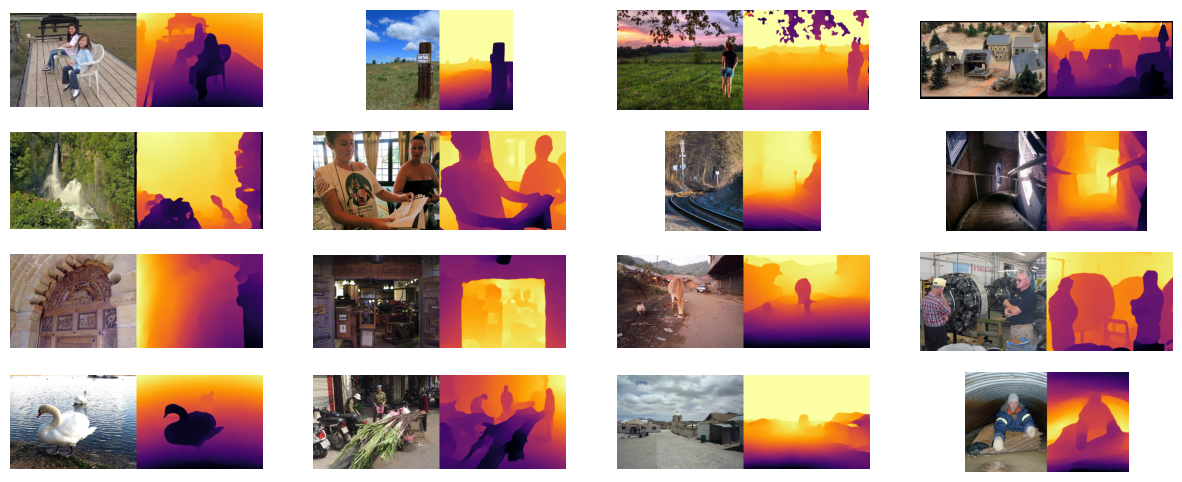

In [11]:
def colored_depthmap(depth, d_min=None, d_max=None,cmap=plt.cm.inferno):
    if d_min is None:
        d_min = np.min(depth)
    if d_max is None:
        d_max = np.max(depth)
    depth_relative = (depth - d_min) / (d_max - d_min)
    return 255 * cmap(depth_relative)[:,:,:3] # H, W, C

def merge_into_row(input, depth_target):
    input = np.array(input)
    depth_target = np.squeeze(np.array(depth_target))

    d_min = np.min(depth_target)
    d_max = np.max(depth_target)
    depth_target_col = colored_depthmap(depth_target, d_min, d_max)
    img_merge = np.hstack([input, depth_target_col])

    return img_merge

plt.figure(figsize=(15, 6))
for i, idx in enumerate(np.random.randint(0,len(dataset_df),(16,))):
    ax = plt.subplot(4, 4, i + 1)
    image = Image.open(dataset_df.iloc[idx,0]).convert('RGB')
    mask = Image.open(dataset_df.iloc[idx,1]).convert('L')
    image_viz = merge_into_row(
        image,mask
    )
    plt.imshow(image_viz.astype("uint8"))
    plt.axis("off")

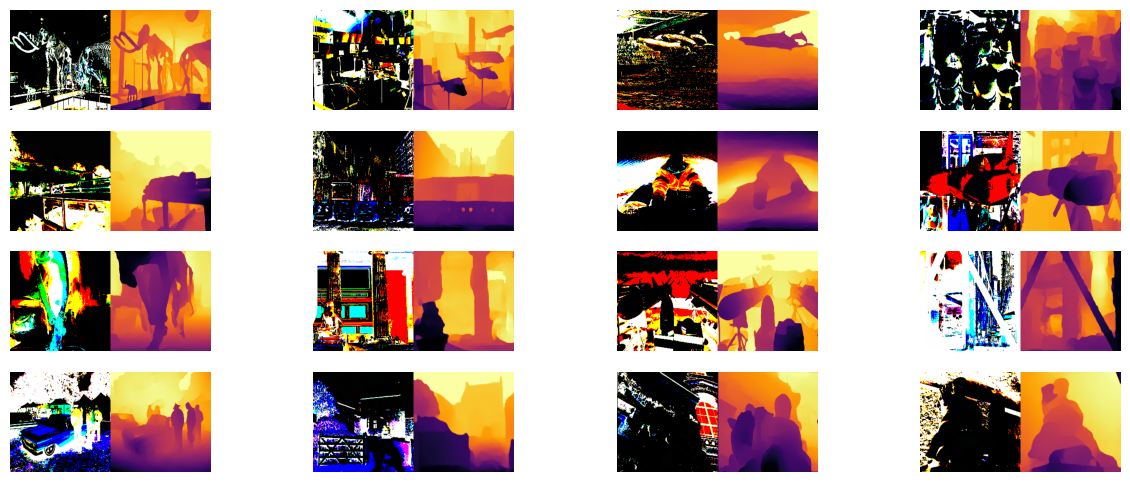

In [15]:
randoms = [test_ds[idx] for idx in range(16)]
plt.figure(figsize=(15, 6))
for i, (img,mask) in enumerate(randoms):
    ax = plt.subplot(4, 4, i + 1)
    img, mask = img.permute(1,2,0).numpy(), mask.permute(1,2,0).numpy()
    mask = colored_depthmap(np.squeeze(mask))
    image_viz = np.hstack([img,mask])
    plt.imshow(image_viz.astype("uint8"))
    plt.axis("off")

In [16]:
train_dl = torch.utils.data.DataLoader(train_ds,shuffle=True,batch_size=64)
val_dl = torch.utils.data.DataLoader(val_ds,shuffle=False,batch_size=64)
test_dl = torch.utils.data.DataLoader(test_ds, shuffle=True, batch_size=4)
len(train_dl), len(val_dl), len(test_dl)

(45, 6, 10)

In [17]:

class ResnetFF(nn.Module):
    def __init__(self, encoder_name='resnext50_32x4d', in_channels=3, classes=1):
        super().__init__()
        self.encoder = smp.encoders.get_encoder(encoder_name, in_channels=in_channels)
        self.decoder = smp.unet.decoder.UnetDecoder(
            encoder_channels=self.encoder.out_channels,
            decoder_channels=(256, 128, 64, 32),
            n_blocks=(3, 2, 1, 0),
            use_batchnorm=True,
            center=False,
            attention_type=None,  # You can change this to 'scse' or 'cbam' for attention mechanisms
        )
        self.segmentation_head = smp.unet.model.UnetHead(
            in_channels=self.decoder.out_channels[-1], out_channels=classes, activation=None
        )

    def trainable_encoder(self, trainable=True):
        for p in self.encoder.parameters():
            p.requires_grad = trainable

    def forward(self, x):
        features = self.encoder(x)
        decoder_output = self.decoder(*features)
        logits = self.segmentation_head(decoder_output[-1])
        return logits

    def _num_params(self):
        return sum([p.numel() for p in self.parameters() if p.requires_grad])

model = ResnetFF(encoder_name='resnext50_32x4d', in_channels=3, classes=1)

In [18]:
class UnNormalize(Normalize):
    def __init__(self,*args,**kwargs):
        mean=(0.485, 0.456, 0.406)
        std=(0.229, 0.224, 0.225)
        new_mean = [-m/s for m,s in zip(mean,std)]
        new_std = [1/s for s in std]
        super().__init__(new_mean, new_std, *args, **kwargs)

@torch.no_grad()
def plot_vals(imgs, preds, targets,n=4,figsize=(6,2),title=''):
    plt.figure(figsize=figsize,dpi=150)
    r = 2 if n == 4 else 8
    c = 2
    for i,idx in enumerate(np.random.randint(0,imgs.size(0),(n,))):
        ax = plt.subplot(r,c,i + 1)
        img,pred,gt = imgs[idx], preds[idx], targets[idx]
        img = UnNormalize()(img)*255.
        img,pred,gt = img.permute(1,2,0).numpy(), pred.permute(1,2,0).numpy(), gt.permute(1,2,0).numpy()
        pred = colored_depthmap(np.squeeze(pred))
        gt = colored_depthmap(np.squeeze(gt))
        image_viz = np.hstack([img,pred,gt])
        plt.imshow(image_viz.astype("uint8"))
        plt.axis("off")
    title = f'{title}\input - output - redweb_out' if len(title)!=0 else 'input - output - redweb_out'
    plt.suptitle(title)
    plt.show()

In [19]:
epochs = 5
freeze_epochs = 2
lr = 1e-3

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

metrics = MetricCollection([
    SSIM(data_range=(0,1)),
    MSE()
]).to(device)
train_metrics = metrics.clone()
val_metrics = metrics.clone()

logs = pd.DataFrame()
logs[['loss_train','loss_val','ssim_train','ssim_val','mse_train','mse_val']]=None

model = model.to(device)
model.trainable_encoder(trainable=False)

loss_fn = EdgeguidedRankingLoss()
optim = torch.optim.AdamW(model.parameters(),lr=lr / 25.,weight_decay=0.02)
sched = torch.optim.lr_scheduler.OneCycleLR(optim,max_lr=lr,epochs=epochs,steps_per_epoch=(len(train_dl)))

scaler = GradScaler()

cuda


Downloading: "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-7cdf4587.pth
100%|██████████| 95.8M/95.8M [00:00<00:00, 238MB/s]


training decoder only


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


  0%|          | 0/6 [00:00<?, ?it/s]



  loss_train  loss_val ssim_train  ssim_val mse_train   mse_val
0   0.648853  0.226287   0.136301  0.185004  0.648853  0.225426


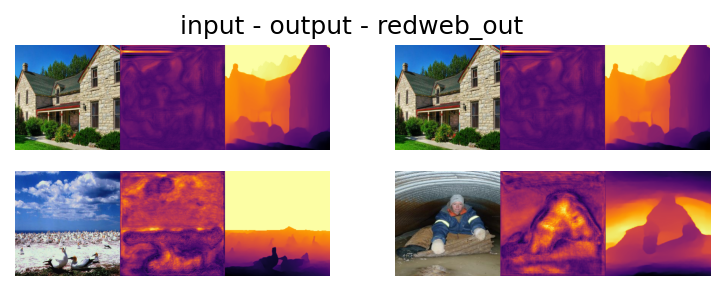

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]



  loss_train loss_val ssim_train  ssim_val mse_train   mse_val
1   0.051893  0.04105   0.566209  0.571114  0.051893  0.041102


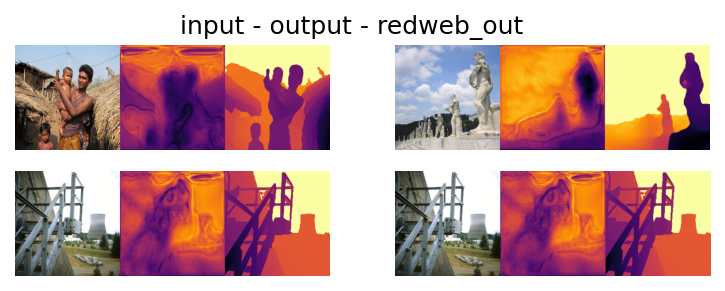

training encoder and decoder both


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]



  loss_train  loss_val ssim_train  ssim_val mse_train   mse_val
2    0.05496  0.052545   0.641519  0.611616   0.05496  0.053002


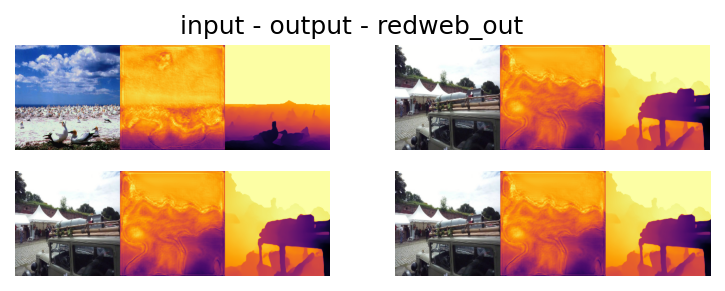

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]



  loss_train  loss_val ssim_train  ssim_val mse_train   mse_val
3    0.04948  0.039877   0.670676  0.630191   0.04948  0.039895


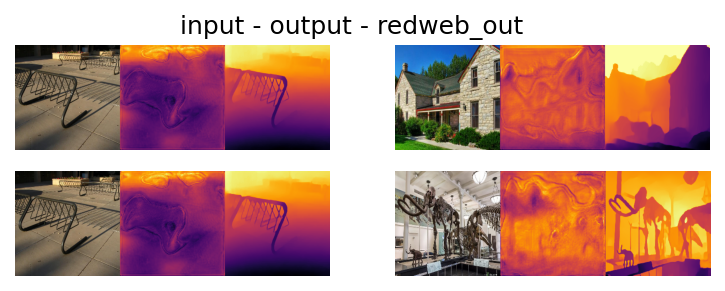

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]



  loss_train  loss_val ssim_train  ssim_val mse_train  mse_val
4   0.044071  0.037185   0.678429  0.635818  0.044071  0.03726


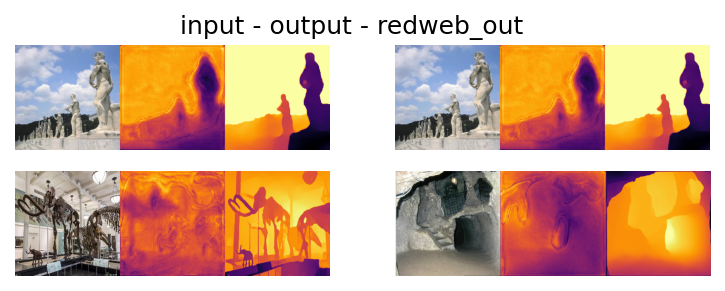

In [20]:
best_ssim = -1e9
best_epoch = -1

print('training decoder only')

for epoch in tqdm(range(epochs)):

    model.train()

    if epoch == freeze_epochs:
        model.trainable_encoder(trainable=True)
        print('training encoder and decoder both')

    running_loss = 0.
    train_prog = tqdm(train_dl,total=len(train_dl))

    for img, mask in train_prog:

        with autocast():
            img, mask = img.to(device), mask.to(device)
            preds = model(img)

            loss = loss_fn(preds,mask)
            scaler.scale(loss).backward()
            scaler.unscale_(optim)
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0, norm_type=2)
            scaler.step(optim)
            scaler.update()
            sched.step()
            optim.zero_grad()

            running_loss += loss.item()

            train_prog.set_description(f'loss: {loss.item():.3f}')
            train_metrics(preds,mask)

        del img, mask, preds, loss

    m = train_metrics.compute()
    _ssim,_mse = m['StructuralSimilarityIndexMeasure'].cpu().item(), m['MeanSquaredError'].cpu().item()
    logs.loc[epoch,['loss_train','ssim_train','mse_train']] = (running_loss/len(train_dl),_ssim,_mse)
    train_metrics.reset()
    model.eval()

    with torch.no_grad():

        running_loss = 0.

        val_prog = tqdm(val_dl,total=len(val_dl))
        for img, mask in val_prog:

            with autocast():
                img, mask = img.to(device), mask.to(device)
                preds = model(img)
                loss = loss_fn(preds,mask)
                running_loss += loss.item()
                val_prog.set_description(f'loss: {loss.item():.3f}')

                val_metrics(preds, mask)

            del img, mask, preds, loss

        m = val_metrics.compute()
        _ssim,_mse = m['StructuralSimilarityIndexMeasure'].cpu().item(), m['MeanSquaredError'].cpu().item()
        logs.loc[epoch,['loss_val','ssim_val','mse_val']] = (running_loss/len(val_dl),_ssim,_mse)
        val_metrics.reset()

    if _ssim > best_ssim:
        best_ssim = _ssim
        best_epoch = epoch
        sd = model.state_dict()
        torch.save(sd,'ResnetFF.pt')

    print(f"\n\n{logs.tail(1)}\n\n")

    with torch.no_grad():
        with autocast():
            img, mask = next(iter(test_dl))
            img, mask = img.to(device), mask.to(device)
            preds = model(img)
            plot_vals(
                img.cpu(),
                preds.cpu(),
                mask.cpu()
            )

    gc.collect()
    torch.cuda.empty_cache()